# Домашнее задание №4: «Байес на страже SMS»

In [1]:
import numpy as np

## Data

### Dataset reading and parsing.

In [2]:
def read_data(path="spam"):
    """
    Reading data from the file.
    
    :param path: path to file to open
    :return tuple matrix of features and list of classes
    """
    with open(path) as dataset:
        raw_lines = dataset.readlines()
        marked_lines = list(tuple(l.rstrip('\n').split('\t'))
                            for l in raw_lines)
        y, X = map(list, zip(*marked_lines))
        return X, y

### Vectorization

In [3]:
from functools import reduce
import itertools
import re


def vectorize(N):
    """
    Giving a list of sentenses, construct a bag of words matrix. 
    Not very efficient/clever/nice way to do it, still fast through.
    
    :param N: list of sentences
    :return: bag of words repr
    """
    # Making DFA for finding words.
    wp = re.compile("\w+")
    # Presaving splitting to words for each string.
    words = list(map(wp.findall, N))
    # Making vocabulary & place for all words in it.
    all_words = set(itertools.chain.from_iterable(words))
    m = len(all_words)
    place = dict((w[1], w[0]) for w in enumerate(all_words))
    # Define function to map.
    def f(wl):
        a = np.zeros(m)
        for w in wl:
            a[place[w]] += 1
        return a
    # Return numpy matrix.
    return np.array(list(map(f, words)))

### Data preparing

In [4]:
def prepare_data(X, y):
    """
    Giving a tuple of sentences list and class array, preprocess
    them into numpy matrix and array with numerical features only.
    
    :param X: list of sentences
    :param Y: classes array
    :return: a tuple of numpy matrix, numpy array and dict, mapping
    class num to string id.
    """
    X = vectorize(X)
    dl = list(enumerate(np.unique(y)))
    s2c = dict((t[1], t[0]) for t in dl)
    return X, np.apply_along_axis(np.vectorize(lambda s: s2c[s]), 0, y), dict(dl)

### Data splitting

In [5]:
from sklearn.model_selection import train_test_split

### Proceed

In [6]:
X_raw, y_raw = read_data()
X, y, class_dict = prepare_data(X_raw, y_raw)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Visualization

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
%matplotlib inline

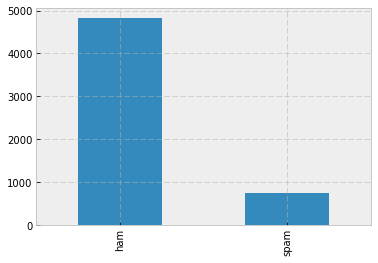

In [8]:
plt.style.use('bmh')
pd.DataFrame.from_dict(Counter(y_raw), orient="index").plot(kind="bar", legend=None)

## Bayes

In [9]:
class NaiveBayes:
    def __init__(self, alpha):
        self.alpha = alpha

    def fit(self, X, y):
        # Size of the vocabulary (= number of words).
        m = X.shape[1]
        # A priori probability for classes.
        C, P = np.unique(y, return_counts=True)
        self.P = P / y.size
        # Sum of number of words for each class.
        S = np.bincount(y, X.sum(axis=1))
        # Calc thetta with additive smoothing.
        self.thetta = np.apply_along_axis(lambda c: (X[y == c].sum(axis=0) + self.alpha) / (S[c] + self.alpha * m),
                                          1,
                                          C.reshape((C.size, 1)))

    def predict(self, X):
        return (np.dot(X, np.log(self.thetta.T)) + np.log(self.P)).argmax(axis=1)

    def score(self, X, y):
        return (self.predict(X) == y).sum() / y.size

## Main

In [10]:
nb = NaiveBayes(alpha=1)
nb.fit(X_train, y_train)
nb.score(X_test, y_test)

0.97399103139013454